In [1]:
%matplotlib inline

import sys
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

1.8.0


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [5]:
def generator(z, out_dim, n_units=128, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        alpha=0.01
        
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Hidden layer
        h2 = tf.layers.dense(h1, n_units, activation=None)
        
        # Leaky ReLU
        h2 = tf.maximum(alpha * h2, h2)
        
        # Logits and tanh output
        out = tf.layers.dense(h2, out_dim, activation=tf.nn.tanh)
        
        return out

def discriminator(x, n_units=128, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.01
        
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Dropout
        h1 = tf.nn.dropout(h1, 0.8)
        
        # Hidden layer
        h2 = tf.layers.dense(h1, n_units, activation=tf.nn.relu)
        
        logits = tf.layers.dense(h2, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
# Size of input image to discriminator
input_size = 28*28
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 256
d_hidden_size = 256

In [7]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
g_model = generator(input_z, input_size, n_units=g_hidden_size)
# g_model is the generator output

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size)

In [8]:
# Calculate losses
'''
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
'''

eps = sys.float_info.epsilon
g_loss = tf.reduce_mean(-tf.log(d_model_fake + eps))
d_loss = tf.reduce_mean(-tf.log(d_model_real + eps) - tf.log(1 - d_model_fake + eps))

In [9]:
# Optimizers
learning_rate = 0.0005

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [10]:
batch_size = 100
epochs = 100
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            # _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True, n_units=g_hidden_size),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.1569... Generator Loss: 2.5856
Epoch 2/100... Discriminator Loss: 0.1562... Generator Loss: 4.3119
Epoch 3/100... Discriminator Loss: 0.1525... Generator Loss: 4.1879
Epoch 4/100... Discriminator Loss: 0.4555... Generator Loss: 2.7764
Epoch 5/100... Discriminator Loss: 0.2602... Generator Loss: 4.5831
Epoch 6/100... Discriminator Loss: 0.5311... Generator Loss: 2.2655
Epoch 7/100... Discriminator Loss: 0.3739... Generator Loss: 3.8733
Epoch 8/100... Discriminator Loss: 0.3440... Generator Loss: 2.4589
Epoch 9/100... Discriminator Loss: 0.3339... Generator Loss: 4.2930
Epoch 10/100... Discriminator Loss: 0.5548... Generator Loss: 2.4418
Epoch 11/100... Discriminator Loss: 0.4431... Generator Loss: 2.5724
Epoch 12/100... Discriminator Loss: 0.5864... Generator Loss: 2.7744
Epoch 13/100... Discriminator Loss: 0.5372... Generator Loss: 2.4360
Epoch 14/100... Discriminator Loss: 0.5140... Generator Loss: 2.7830
Epoch 15/100... Discriminator Loss: 0.7112.

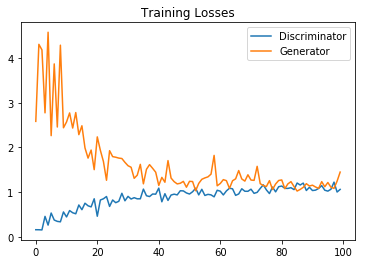

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [12]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [13]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

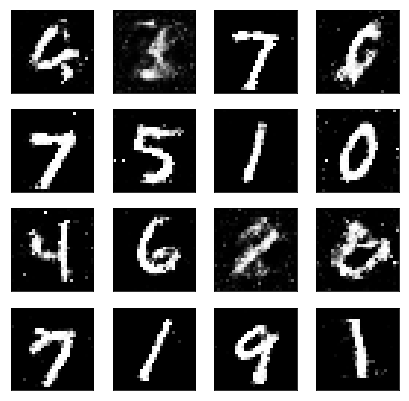

In [14]:
_ = view_samples(-1, samples)

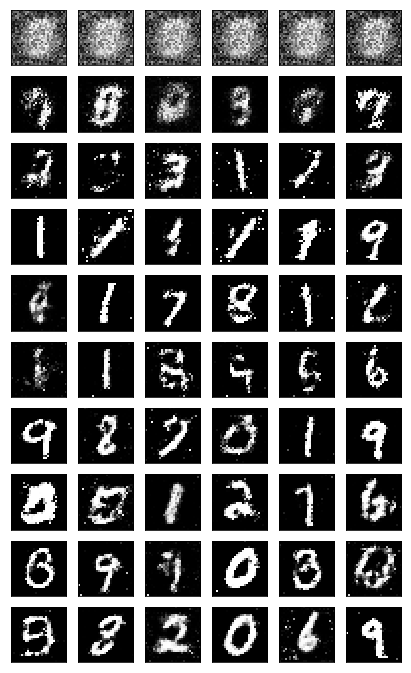

In [15]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


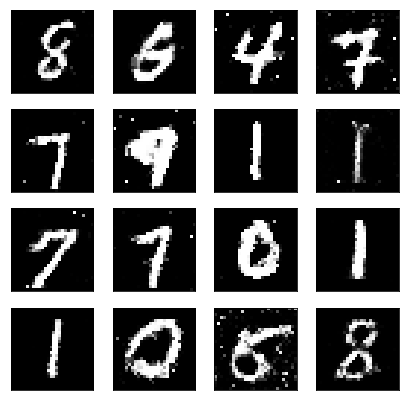

In [16]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, reuse=True, n_units=g_hidden_size),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])